In [2]:
import numpy as np

# 파일 경로 설정
file_path = '/home/minyoungxi/MINYOUNGXI/SMC/10196714/WAVE_10196714_221019.npy'

# NumPy 배열 로드
data = np.load(file_path)

# 데이터의 형태와 일부 내용 출력
data_shape = data.shape
data_content = data if data.size <= 10 else data[:10]  # 데이터가 많을 경우 처음 10개 요소만 출력

data_shape, data_content


((4, 10346751),
 array([[-4.99900011e-03, -4.99900011e-03, -4.99900011e-03, ...,
          1.05001003e-01,  1.12581760e-01,  1.22420534e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.00000000e+01, -5.00000000e+01, -5.00000000e+01, ...,
          7.79153519e+01,  7.63144989e+01,  7.48851013e+01],
        [ 2.73193582e-04,  2.73286132e-04,  2.73378682e-04, ...,
          9.58305418e-01,  9.58305538e-01,  9.58305597e-01]], dtype=float32))

/tmp/ipykernel_94748/2284622558.py:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


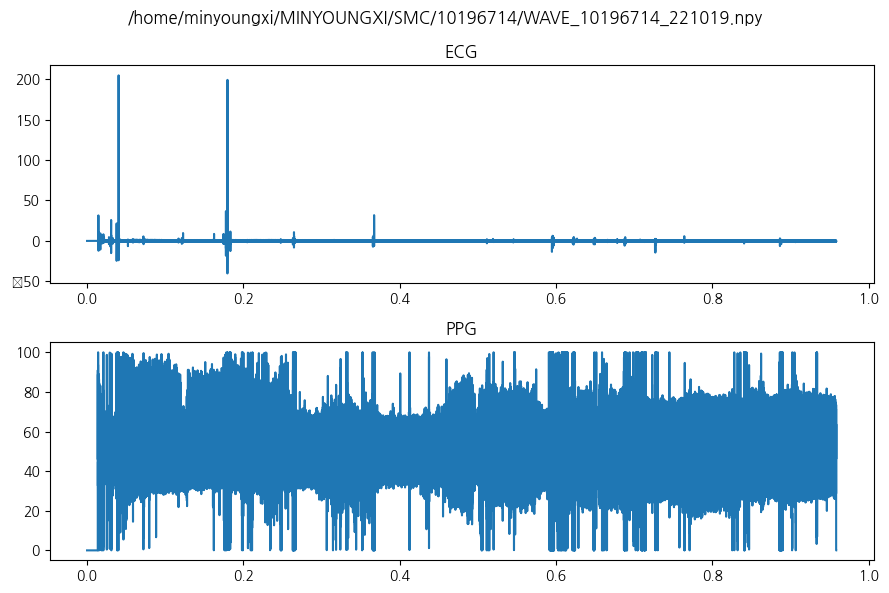

In [5]:
import numpy as np
from matplotlib import pyplot as plt

# 데이터 로드
WAVE = np.load(file_path)
ECG, PPG, t = WAVE[0, :], WAVE[1, :], WAVE[3, :]  # ECG, PPG 데이터와 시간축 추출

# ECG, PPG 시각화
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
fig.suptitle(file_path)

# ECG 시각화
axs[0].plot(t, ECG)
axs[0].set_title('ECG')

# PPG 시각화
axs[1].plot(t, PPG)
axs[1].set_title('PPG')

plt.tight_layout()
plt.show()

In [15]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# LSTM Autoencoder 모델 정의
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True, dropout=dropout_rate)
    
    def forward(self, x):
        # 인코더
        encoded, (hidden, cell) = self.encoder(x)
        
        # 디코더
        decoded, _ = self.decoder(encoded)
        
        return decoded, encoded
    
# 모델 초기화
dropout_rate = 0.2

# 하이퍼파라미터 설정
input_size = 1       # 입력 시퀀스의 차원
hidden_size = 32     # LSTM의 히든 레이어 크기
num_layers = 1       # LSTM 레이어의 개수
learning_rate = 0.001
num_epochs = 100
sequence_length = 100  # 입력 시퀀스의 길이

# 모델, 손실 함수, 옵티마이저 초기화
model = LSTMAutoencoder(input_size, hidden_size, num_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ECG 데이터 로드
ecg_data = WAVE[0, :20000]  # ECG 데이터 추출
ecg_data = torch.from_numpy(ecg_data).float().view(1, -1, 1)  # PyTorch 텐서로 변환

# 데이터를 시퀀스로 나누기
datasets = []
for i in range(ecg_data.size(1) - sequence_length):
    sequence = ecg_data[:, i:i+sequence_length, :]
    datasets.append(sequence)
    
loader = DataLoader(TensorDataset(torch.cat(datasets, dim=0)), batch_size=32, shuffle=True)

# 훈련
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(num_epochs):
    total_loss = 0.0
    for i, sequences in enumerate(loader):
        sequences = sequences[0].to(device)  # 배치 데이터를 디바이스로 이동
        # Forward pass
        outputs, encoded = model(sequences)
        loss = criterion(outputs, sequences)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if (i+1) % 100 == 0:  # 100 배치마다 진행 상황 출력
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(loader)}], Loss: {loss.item():.4f}')
            
    # 에폭이 끝날 때마다 평균 손실 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(loader):.4f}')



/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/100], Batch [100/622], Loss: 0.0000
Epoch [1/100], Batch [200/622], Loss: 0.0000
Epoch [1/100], Batch [300/622], Loss: 0.0000
Epoch [1/100], Batch [400/622], Loss: 0.0000
Epoch [1/100], Batch [500/622], Loss: 0.0000
Epoch [1/100], Batch [600/622], Loss: 0.0000
Epoch [2/100], Batch [100/622], Loss: 0.0000
Epoch [2/100], Batch [200/622], Loss: 0.0000
Epoch [2/100], Batch [300/622], Loss: 0.0000
Epoch [2/100], Batch [400/622], Loss: 0.0000
Epoch [2/100], Batch [500/622], Loss: 0.0000
Epoch [2/100], Batch [600/622], Loss: 0.0000
Epoch [3/100], Batch [100/622], Loss: 0.0000
Epoch [3/100], Batch [200/622], Loss: 0.0000
Epoch [3/100], Batch [300/622], Loss: 0.0000
Epoch [3/100], Batch [400/622], Loss: 0.0000
Epoch [3/100], Batch [500/622], Loss: 0.0000
Epoch [3/100], Batch [600/622], Loss: 0.0000
Epoch [4/100], Batch [100/622], Loss: 0.0000
Epoch [4/100], Batch [200/622], Loss: 0.0000
Epoch [4/100], Batch [300/622], Loss: 0.0000
Epoch [4/100], Batch [400/622], Loss: 0.0000
Epoch [4/1

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


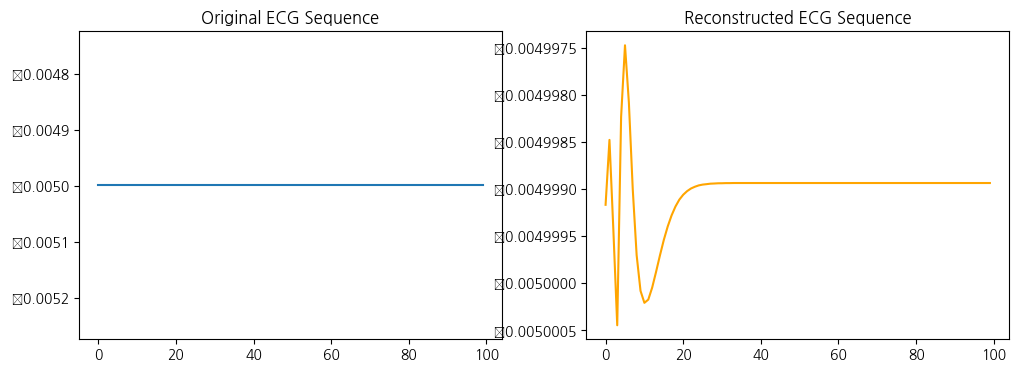

In [17]:
import matplotlib.pyplot as plt

# 테스트 데이터셋에서 배치 하나를 가져옴
test_sequences = next(iter(loader))[0].to(device)

# 모델을 평가 모드로 설정
model.eval()

# Forward pass
with torch.no_grad():
    reconstructed, _ = model(test_sequences)

# 첫 번째 시퀀스의 원본과 재구성된 시퀀스를 가져옴
original_sequence = test_sequences[0].cpu().numpy()
reconstructed_sequence = reconstructed[0].cpu().numpy()

# 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(original_sequence, label='Original')
plt.title('Original ECG Sequence')
plt.subplot(1, 2, 2)
plt.plot(reconstructed_sequence, label='Reconstructed', color='orange')
plt.title('Reconstructed ECG Sequence')
plt.show()
